# ABIC-LiNGAM

## Import and settings
In this example, we need to import `numpy`, `pandas`, and `graphviz` in addition to `lingam`.

In [1]:
import numpy as np
import pandas as pd
import graphviz
from IPython.display import display, HTML

import lingam
from lingam.utils import make_dot
from lingam.utils import MGGD, MGGDEstimator

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=5, suppress=True)
np.random.seed(42)

['1.26.4', '2.3.0', '0.20.3', '1.11.0']


## Test data
We create test data consisting of 6 variables.

In [2]:
d = 4
B_true = np.zeros((d, d), dtype=float)
B_true[0, 1] = 1.0    # x0 -> x1
B_true[1, 2] = -1.5   # x1 -> x2
B_true[2, 3] = 1.0    # x2 -> x3

omega_true = np.array([
    [1.2, 0.0, 0.0, 0.0],
    [0.0, 1.0, 0.0, 0.6],  # x1 <-> x3
    [0.0, 0.0, 1.0, 0.0],
    [0.0, 0.6, 0.0, 1.0],
], dtype=float)

n = 1000
beta_shape = 3.0  # Non-Gaussian (Gaussian if β=1)

mggd = MGGD(np.zeros(d), omega_true, beta_shape)
eps = mggd.rvs(size=n)

A = np.eye(d) - B_true
X = eps @ np.linalg.inv(A)
X -= X.mean(axis=0, keepdims=True)
X = pd.DataFrame(X, columns=['x0', 'x1', 'x2', 'x3'])
X.head()

,x0,x1,x2,x3
0,0.707924,0.285412,0.000765,-0.325608
1,0.551189,1.152744,-2.345113,-1.553441
2,-0.163441,0.294779,-0.336241,0.339230
3,-0.229596,-0.679928,0.982231,0.562654
4,0.412978,-0.391069,0.112635,-0.541435


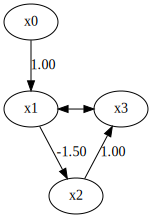

In [3]:
# Merge the coefficient matrix and the error covariance matrix to create the true graph.
omega = omega_true.copy()
np.fill_diagonal(omega, 0.0)
graph_true = B_true.T.copy()
graph_true[np.abs(omega) > 0] = np.nan

make_dot(graph_true)

## Causal Discovery

To run causal discovery, we create a `ABICLiNGAM` object and call the `fit` method. Here, we set the parameter `beta` estimated using the MGGD estimator.

In [4]:
est = MGGDEstimator()
mggd_est = est.fit(X.values)
beta_hat = float(mggd_est.beta)
print(f"beta_hat: {beta_hat}")

model = lingam.ABICLiNGAM(beta=beta_hat)
model.fit(X)

beta_hat: 2.6066582934794456


Using the `coefficient_matrix_` and `error_covariance_matrix_` properties, we can see the estimated coefficient matrix and the error covariance matrix.

In [5]:
print("Estimated directed B:\n", model.coefficient_matrix_, "\n")
print("Estimated bidirected Omega:\n", model.error_covariance_matrix_)

Estimated directed B:
 [[ 0.       1.00579  0.       0.     ]
 [ 0.       0.      -1.52555  0.     ]
 [ 0.       0.       0.       0.99481]
 [ 0.       0.       0.       0.     ]] 

Estimated bidirected Omega:
 [[0.27928 0.      0.      0.     ]
 [0.      0.22923 0.      0.13404]
 [0.      0.      0.22453 0.     ]
 [0.      0.13404 0.      0.22539]]


Additionally, as with other algorithms, using the `causal_order_` and `adjacency_matrix_` properties allows you to see the causal order and adjacency matrix  (with nan values for unobserved common causes).

In [6]:
print("Causal ordering =", model.causal_order_, "\n")
print("Estimated adjacency_matrix:\n", model.adjacency_matrix_)

Causal ordering = [0, 1, 2, 3] 

Estimated adjacency_matrix:
 [[ 0.       0.       0.       0.     ]
 [ 1.00579  0.       0.           nan]
 [ 0.      -1.52555  0.       0.     ]
 [ 0.           nan  0.99481  0.     ]]


Next, we compare the estimation results using DirectLiNGAM with the same data.

In [7]:
# DirectLiNGAM
dl = lingam.DirectLiNGAM()
dl.fit(X)

true_svg = make_dot(graph_true).pipe(format='svg').decode('utf-8')
svg1 = make_dot(model.adjacency_matrix_).pipe(format='svg').decode('utf-8')
svg2 = make_dot(dl.adjacency_matrix_).pipe(format='svg').decode('utf-8')

# Display side by side using HTML
html = f"""
<div style="display: flex; gap: 40px; align-items: flex-start;">
  <div>
    <h3 style="text-align: center;">Ground Truth</h3>
    {true_svg}
  </div>
  <div>
    <h3 style="text-align: center;">ABIC-LiNGAM</h3>
    {svg1}
  </div>
  <div>
    <h3 style="text-align: center;">DirectLiNGAM</h3>
    {svg2}
  </div>
</div>
"""

display(HTML(html))